In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from trace_process import *

from tsai.all import *
computer_setup()

os             : Linux-5.15.0-48-generic-x86_64-with-glibc2.35
python         : 3.9.4
tsai           : 0.3.1
fastai         : 2.7.9
fastcore       : 1.5.26
torch          : 1.11.0
device         : 1 gpu (['NVIDIA GeForce RTX 3080 Ti'])
cpu cores      : 24
RAM            : 31.27 GB
GPU memory     : [12.0] GB


In [2]:
MTU = 1514
MB = 1024 * 1024
KB = 1024
GB = 1024 * 1024 * 1024
SECONDS = 1e9
WINDOW = 5
STRIDE = WINDOW

PACKETS = "../data/17/node-1/train/packets"

In [3]:
def get_packets(file_path):
    df = pd.read_csv(
        file_path, 
        header=None,
        index_col=False,
        names=['timestamp', 'size', 'src', 'dest', 'dir'], 
        dtype={'src': "category", 'dest': "category", "dir": "int8"},
    )
    df = df[df['dir'] == 1][["timestamp", "size"]]
    df = df.sort_values(by='timestamp')
    df['nexttime'] = df['timestamp'] - df['timestamp'].shift(1)
    df['nexttime'] = (df['nexttime'] - df['nexttime'].min()) / (df['nexttime'].max() - df['nexttime'].min())
    df['timestamp'] = (df['timestamp'] - df['timestamp'].min()) / (df['timestamp'].max() - df['timestamp'].min())
    df['size'] = (df['size'] - df['size'].mean()) / df['size'].std()
    df = df[1:]
    return df

In [4]:
df = get_packets(PACKETS)

In [5]:
window_length = WINDOW
stride = STRIDE

X, y = SlidingWindow(window_length, stride=stride, get_y=['size'])(df)

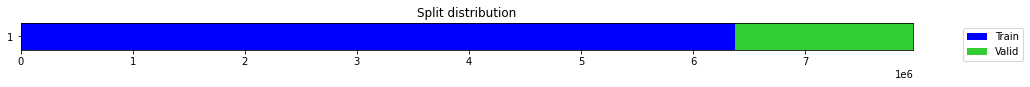

In [6]:
bs = 64
n_epochs = 10
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=False)
dsets = TSDatasets(X, y, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

In [7]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())

epoch,train_loss,valid_loss,_rmse,time
0,1.058280,0.935750,0.967346,14:42
1,1.064305,0.934062,0.966463,14:55
2,1.026657,1.000902,1.000457,15:06
3,1.023352,1.002039,1.001082,14:50
4,1.000062,0.999971,1.000005,15:12


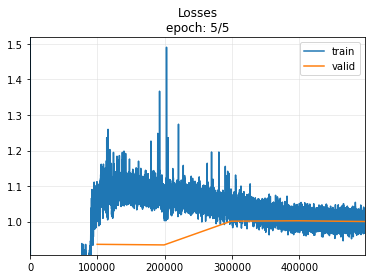

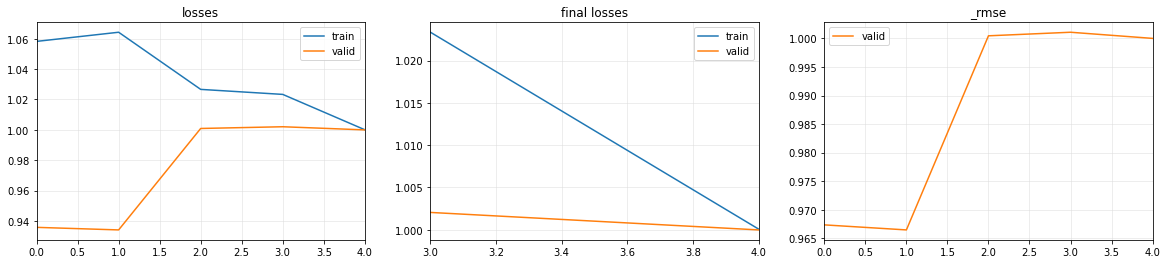

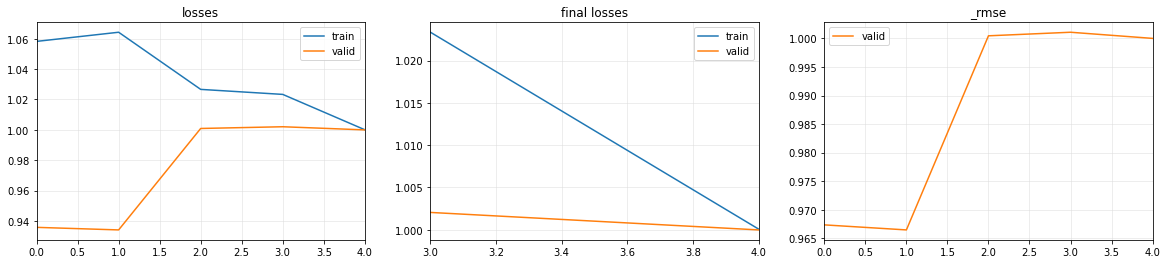

<function tsai.metrics.mae(inp, targ)>

In [8]:
model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mse, rmse],  cbs=ShowGraph())
learn.fit_one_cycle(5, 2e-2)
learn.plot_metrics()
beep()

SuggestedLRs(valley=0.0020892962347716093)

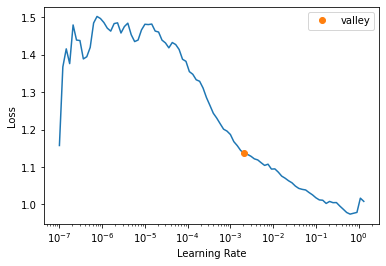

In [7]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mse,_rmse,time
0,0.574988,0.709553,0.709553,0.842349,21:13
1,0.680343,0.672709,0.672709,0.820189,19:55
2,0.642703,0.686878,0.686878,0.828779,20:10
3,0.639460,0.694711,0.694711,0.833492,20:41
4,0.663594,0.704356,0.704356,0.839259,21:06


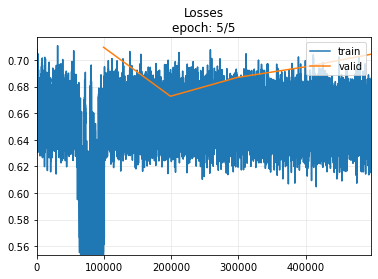

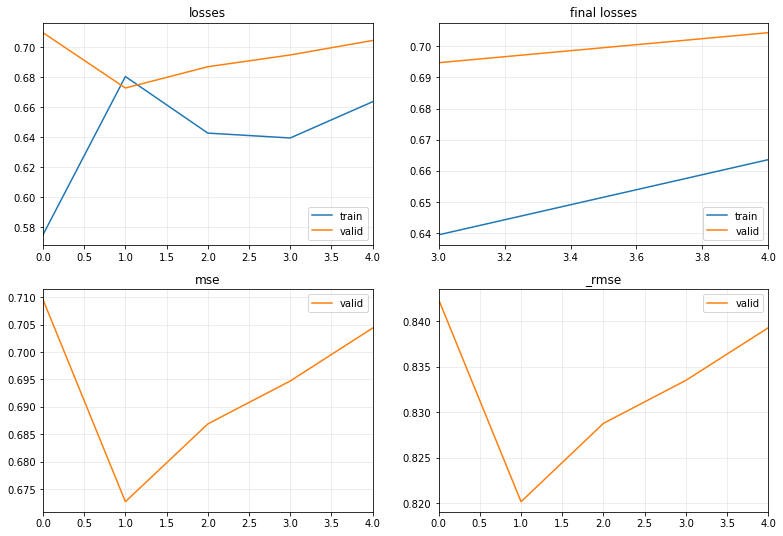

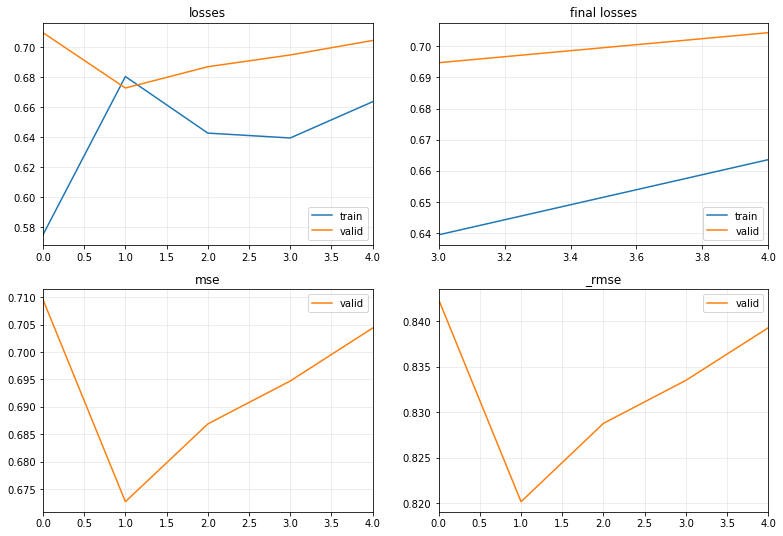

In [8]:
learn = ts_learner(dls, InceptionTime, loss_func=MSELossFlat(), metrics=[mse, rmse],  cbs=ShowGraph())
learn.fit_one_cycle(5, 1e-2)
learn.plot_metrics()
beep()